In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print( os.getcwd() )

/Users/austinclime/vs_code_projects/vix_approx/vix_approx_research/VIX_SKEW_replication


In [72]:
import io
import pandas as pd
import numpy as np
#import pyarrow as pa
#import pyarrow.parquet as pq
#import pyarrow.csv as pv

from io import StringIO
from datetime import timedelta
import pytz
import datetime

#import pandas_datareader.data as web
import pandas_market_calendars as mcal
from scipy.interpolate import CubicSpline, interp1d

### Pulling OptionMetrics data off box

In [303]:
from vix_calculator import (retreiev_OM_data,
                            filter_option_types_and_expirations,
                            add_expiration_time,
                            calculate_interest_rates,
                            calculate_sigma_sq,
                            calculate_vix_daily)

In [15]:


periods_dict={0:{'year':2022,'month':1} , 
            1:{'year':2023,'month':3},          
            }
# 1:{'year':2023,'month':3}}
OM_df_pull=retreiev_OM_data(periods_dict)
print(OM_df_pull.shape)

### Calculating (using cached df)

In [6]:
df=pd.read_csv('SPX_2023_2.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,...,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix
0,0,0,108105.0,2023-02-01,SPX 230217C1000000,1,2023-02-17,2023-01-26,C,1000000.0,...,NaN,144702199.0,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN
1,1,1,108105.0,2023-02-01,SPX 230217C1200000,1,2023-02-17,2022-07-28,C,1200000.0,...,NaN,144702200.0,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN
2,2,2,108105.0,2023-02-01,SPX 230217C1300000,1,2023-02-17,NaN,C,1300000.0,...,NaN,144702201.0,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN
3,3,3,108105.0,2023-02-01,SPX 230217C1400000,1,2023-02-17,NaN,C,1400000.0,...,NaN,144702202.0,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN
4,4,4,108105.0,2023-02-01,SPX 230217P3090000,1,2023-02-17,2023-01-30,P,3090000.0,...,-29.18494,150042908.0,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN


In [17]:
df2=filter_option_types_and_expirations(df)
print( df2[~df2.symbol.str.contains('SPXW')].exp_code.unique() )
df2.head()

[2]


,Unnamed: 0.1,Unnamed: 0,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,...,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,exp_code,holiday_exp
0,0,0,108105.0,2023-02-01,SPX 230217C1000000,1,2023-02-17,2023-01-26,C,1000000.0,...,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN,2,False
1,1,1,108105.0,2023-02-01,SPX 230217C1200000,1,2023-02-17,2022-07-28,C,1200000.0,...,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN,2,False
2,2,2,108105.0,2023-02-01,SPX 230217C1300000,1,2023-02-17,NaT,C,1300000.0,...,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN,2,False
3,3,3,108105.0,2023-02-01,SPX 230217C1400000,1,2023-02-17,NaT,C,1400000.0,...,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN,2,False
4,4,4,108105.0,2023-02-01,SPX 230217P3090000,1,2023-02-17,2023-01-30,P,3090000.0,...,1.0,1.0,100.0,0,NaN,NaN,NaN,NaN,2,False


In [ ]:
df2[df2.exp_code==0].exdate.unique()
#df2[df2.holiday_exp==True]

df2.exp_code.unique()

In [42]:
df3=add_expiration_time(df2)

In [264]:
df5=df3.copy() #skipping to df5

CMT=30 #constant maturity term: 30days
CMT_mins=CMT*24*60
mins_in_year=365*24*60
df5['time_to_exp']=df5['ex_time']-df5['datetime_close']
df5['midpoint_price']=(df5.best_bid+df5.best_offer)/2
df5['strike_price']/=1000
#create sub function that does groupby('date).apply()




### Calculate the VIX by day

In [140]:
day_df=df5[df5.date=='2023-02-01']
#temp=df5[df5.date=='2023-02-22']

unique_expirs=day_df.ex_time.unique()
#print(unique_expirs)
const_matur_expir=day_df.iloc[0].datetime_close+timedelta(days=CMT) #constant maturity expir
#print(const_matur_expir)

#Find closest expiration to the CMT expiration without going over
near_term_exp=max(unique_expirs[unique_expirs<=const_matur_expir])
near_term_df=day_df[day_df.ex_time==near_term_exp]
#Find closest expiration to the CMT expiration that is strictly above
next_term_exp=min(unique_expirs[unique_expirs>const_matur_expir])
next_term_df=day_df[day_df.ex_time==next_term_exp]

#CAN USE THIS TO GET DATE WHEN GROUPBY
current_date=day_df.iloc[0].datetime_close.date() #current date
current_date

#minutes to expiration
near_term_mins=near_term_df.time_to_exp.iloc[0].total_seconds()/60
next_term_mins=next_term_df.time_to_exp.iloc[0].total_seconds()/60
t_near,t_next=near_term_mins/mins_in_year,next_term_mins/mins_in_year
print(t_near,t_next)

0.0821917808219178 0.10136986301369863


In [137]:
#next_term_df
#day_df.iloc[0].time_to_exp.days
#next_term_df.iloc[0].time_to_exp.days
#near_term_df.iloc[0].time_to_exp.days

In [141]:
#Interest rate calculation
r_near=calculate_interest_rates(current_date,near_term_df.iloc[0].time_to_exp.days)
r_next=calculate_interest_rates(current_date,next_term_df.iloc[0].time_to_exp.days)
print(r_near)
print(r_next)

0.04528346096164907
0.045420322052583256


In [267]:
sigma_sq_near=calculate_sigma_sq(near_term_df,r_near,t_near)
sigma_sq_next=calculate_sigma_sq(next_term_df,r_next,t_next)

first_term=t_near*sigma_sq_near*((next_term_mins-CMT_mins)/(next_term_mins-near_term_mins))
second_term=t_next*sigma_sq_next*((CMT_mins-near_term_mins)/(next_term_mins-near_term_mins))
sigma=np.sqrt((first_term+second_term)*(mins_in_year/CMT_mins))*100
#CMT_mins
#near_term_mins
#next_term_mins
#mins_in_year
print(current_date)
sigma

2023-02-01


18.11464802873

In [305]:
#day_df=df5[df5.date=='2023-02-01']
vix_dict={}
excl_dates=[]
for day_i in df5.date.unique():
    print(str(day_i.date()))
    day_df_i=df5[df5.date==str(day_i.date())]
    try:
        sigma=calculate_vix_daily(day_df_i)
        #print(sigma)
        vix_dict[str(day_i.date())]=sigma
    except:
        print(f'error with {str(day_i.date())}')
        #excl_dates.append(str(day_i.date()))
        #display(day_df.head())

vix_dict

2023-02-01
2023-02-02
2023-02-03
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-27
2023-02-28


{'2023-02-01': 18.11464802873,
 '2023-02-02': 18.36531906784232,
 '2023-02-03': 18.43445154285153,
 '2023-02-06': 19.45005128768449,
 '2023-02-07': 18.534239741166914,
 '2023-02-08': 19.64286159991167,
 '2023-02-09': 20.7800860567035,
 '2023-02-10': 20.5488000719817,
 '2023-02-13': 20.459527485107916,
 '2023-02-14': 18.748997028699765,
 '2023-02-15': 18.279322778279724,
 '2023-02-16': 20.16689285881481,
 '2023-02-17': 19.9002921379212,
 '2023-02-21': 22.999181897600753,
 '2023-02-22': 22.435989608370996,
 '2023-02-23': 21.118351810024073,
 '2023-02-24': 21.717868368829507,
 '2023-02-27': 21.192144290095577,
 '2023-02-28': 20.585721754266935}

In [317]:
path='/Users/austinclime/vs_code_projects/vix_approx/vix_approx_research/pulling_data/CBOE/vix_hist.csv'
vix_hist=pd.read_csv(path,index_col='date').iloc[:,1:]
#vix_hist
vix_rep_df=pd.DataFrame.from_dict(vix_dict,orient='index')
vix_rep_df.index.name='Date'
vix_rep_df.columns=['vix_rep']
vix_merged=vix_rep_df.join(vix_hist,how='inner')[['vix_rep','vix']]


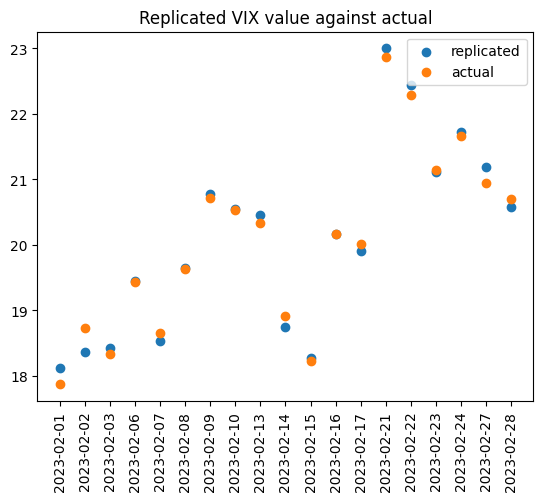

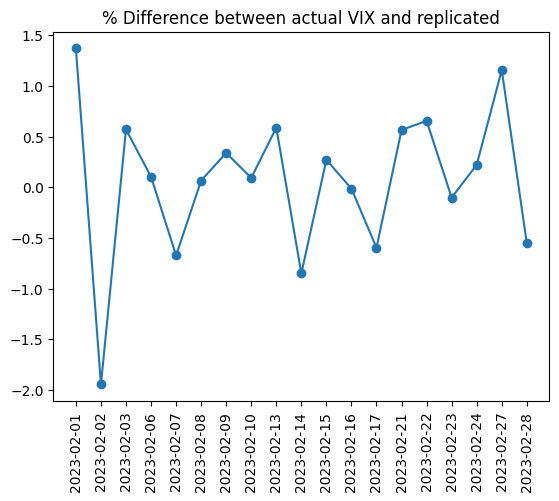

In [331]:
#vix_merged
import matplotlib.pyplot as plt
plt.scatter(vix_merged.index,vix_merged.vix_rep,label='replicated')
plt.scatter(vix_merged.index,vix_merged.vix,label='actual')
plt.title('Replicated VIX value against actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.plot(vix_merged.index,(vix_merged.vix_rep/vix_merged.vix-1)*100,marker='o',linestyle='-')
plt.title('% Difference between actual VIX and replicated')
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(r_near,t_near)
near_term_df

ATM_strike_cands=near_term_df[~( (pd.isnull(near_term_df.best_bid)) | (pd.isnull(near_term_df.best_offer)) ) 
             & ~(near_term_df.best_bid>near_term_df.best_offer) 
             & ~( (near_term_df.best_bid<=0)  )  ]

def min_strike_diff(slice):
    #display(slice[slice.cp_flag=='P'])
    if ('C' in slice.cp_flag.unique()) and ('P' in slice.cp_flag.unique()):
        return abs( slice[slice.cp_flag=='P'].midpoint_price.values[0] - slice[slice.cp_flag=='C'].midpoint_price.values[0])

#F_strike=near_term_df.groupby(['strike_price']).apply(min_strike_diff).idxmin()

F_strike=ATM_strike_cands.groupby(['strike_price']).apply(min_strike_diff).idxmin()
call_put_diff=ATM_strike_cands[(ATM_strike_cands.strike_price==F_strike)].sort_values(by='cp_flag')['midpoint_price'].diff().dropna().values[0]
F=F_strike+np.exp(r_near*t_near)*call_put_diff
#near_term_df[near_term_df.strike_price==4125]
print(F)
K0=near_term_df[near_term_df.strike_price<=F].strike_price.max()
print(K0)

#near_term_df[(near_term_df.strike_price<K0)&(near_term_df.best_bid<=0)][['best_bid','best_offer','strike_price','midpoint_price']]
#near_term_df.strike_price.unique()

#opt_type='put'
def filter_included_options(opt_type):
    if opt_type=='put':
        OOM_opts=near_term_df[(near_term_df.strike_price<K0)&(near_term_df.cp_flag=='P')]
        OOM_opts=OOM_opts.copy()
        OOM_opts['excl_ind']=OOM_opts.best_bid.apply(lambda x: pd.isnull(x) or x<=0)
        OOM_opts.sort_values(by=['strike_price'],ascending=False,inplace=True) #sort upside down for puts
    else:
        OOM_opts=near_term_df[(near_term_df.strike_price>K0)&(near_term_df.cp_flag=='C')]
        OOM_opts=OOM_opts.copy()
        OOM_opts['excl_ind']=OOM_opts.best_bid.apply(lambda x: pd.isnull(x) or x<=0)
        #dont need to change sorting order for calls

    OOM_opts['excl_ind']=OOM_opts['excl_ind'].cumsum()
    incl_opts=OOM_opts[OOM_opts.excl_ind<2]
    incl_opts=incl_opts[incl_opts.best_bid>0]
    if opt_type=='put':
        incl_opts.sort_values(by=['strike_price'],ascending=True,inplace=True)#change back
    return incl_opts

#incl_opts[['strike_price','cp_flag','best_bid','best_offer']]
incl_puts,incl_calls=filter_included_options('put'),filter_included_options('call')
print(incl_puts.shape)
print(incl_calls.shape)

pca=pd.DataFrame.from_dict({'strike_price':K0,'cp_flag':'P/C Avg', #put-call average
                        'midpoint_price':near_term_df[(near_term_df.strike_price==K0)]['midpoint_price'].mean()},orient='index').T
#pca=near_term_df[(near_term_df.strike_price==K0)]['midpoint_price'].mean()#put-call average

opt_portfolio=pd.concat([incl_puts,pca,incl_calls])[['strike_price','cp_flag','midpoint_price']]
#opt_portfolio['dK']=opt_portfolio.strike_price.diff()
#opt_portfolio.iloc[0]['dK']=opt_portfolio.iloc[1]['dK']
opt_portfolio['dK']=(opt_portfolio.strike_price.shift(-1)-opt_portfolio.strike_price.shift(1))/2
opt_portfolio=opt_portfolio.copy()
opt_portfolio.iloc[0]['dK']=opt_portfolio.iloc[1]['strike_price']-opt_portfolio.iloc[0]['strike_price']
opt_portfolio.iloc[-1]['dK']=opt_portfolio.iloc[-1]['strike_price']-opt_portfolio.iloc[-2]['strike_price']
opt_portfolio['contribution_by_strike']=opt_portfolio.dK/opt_portfolio.strike_price**2
opt_portfolio['contribution_by_strike']*=opt_portfolio['midpoint_price']*np.exp(r_near*t_near)
opt_portfolio

correction_term=(1/t_near)*(F/K0-1)**2
correction_term
sigma_sq=opt_portfolio.contribution_by_strike.sum()*(2/t_near)-correction_term
sigma_sq#**0.5